# GBM without Parameter Tuning 

/shared-libs/python3.10/py/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Performance with Default Hyperparameters:
Accuracy: 0.6590712108927224
Classification Report:
              precision    recall  f1-score   support

          FB       1.00      0.96      0.98      5996
       Insta       0.49      1.00      0.66      5951
         Red       0.00      0.00      0.00      5955
      Reddit       0.62      1.00      0.76      5955
      TikTok       0.99      0.34      0.50      5955
           X       0.94      0.66      0.78      5955

    accuracy                           0.66     35767
   macro avg       0.67      0.66      0.61     35767
weighted avg       0.67      0.66      0.61     35767

Confusion Matrix:
[[5757  232    1    0    0    6]
 [   6 5938    0    0    6    1]
 [   0 5937  

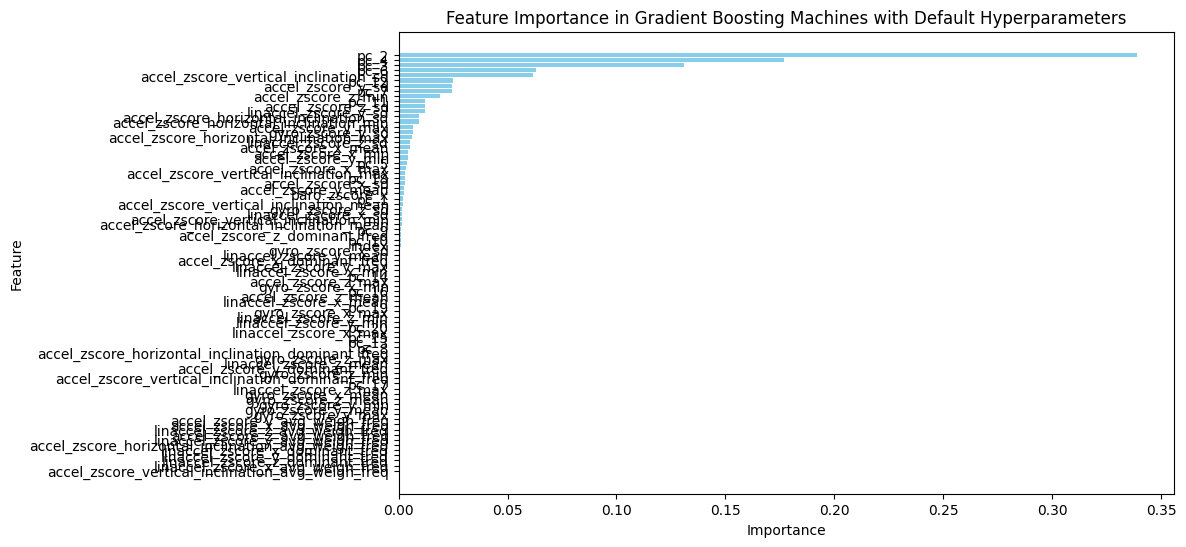

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder

# Load the dataset
full_data = pd.read_parquet("new_full_dataset.parquet.gzip")

# Split the dataset into training and testing sets
random.seed(51)
testing_categories = [1, 2, 3, 4, 5, 6]
random.shuffle(testing_categories)

testing_set = [f"{platform}{number}" for platform, number in zip(full_data["SM_platform"].unique(), testing_categories)]
testing_df = full_data[full_data["source_name"].isin(testing_set)]
training_df = full_data[~full_data["source_name"].isin(testing_set)]

# Only select standardized columns
columns_to_select = [col for col in full_data.columns if 'zscore' in col] + ["SM_platform", "index"] + [col for col in full_data.columns if 'pc' in col]
training_df = training_df.loc[:, columns_to_select]
testing_df = testing_df.loc[:, columns_to_select]

# Separate features and target
X_train = training_df.drop(columns=["SM_platform"])
y_train = training_df["SM_platform"]
X_test = testing_df.drop(columns=["SM_platform"])
y_test = testing_df["SM_platform"]

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train the model with default hyperparameters
default_gbm = GradientBoostingClassifier(random_state=42)
default_gbm.fit(X_train, y_train_encoded)

# Make predictions
y_pred = default_gbm.predict(X_test)

# Decode the predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

# Evaluate the model
print("Performance with Default Hyperparameters:")
print(f"Accuracy: {accuracy_score(y_test_labels, y_pred_labels)}")
print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred_labels))

# Feature importance
importances = default_gbm.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head())

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Gradient Boosting Machines with Default Hyperparameters')
plt.gca().invert_yaxis()
plt.show()


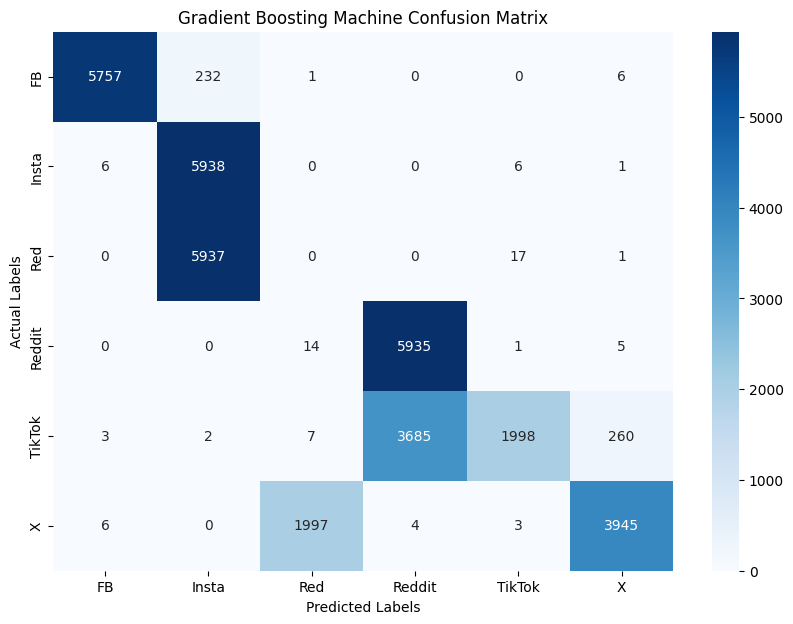

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# Compute confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)

# Convert to DataFrame for better labeling in seaborn heatmap
cm_df = pd.DataFrame(cm,
                     index=[i for i in label_encoder.classes_], 
                     columns=[i for i in label_encoder.classes_])

# Plotting using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title('Gradient Boosting Machine Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


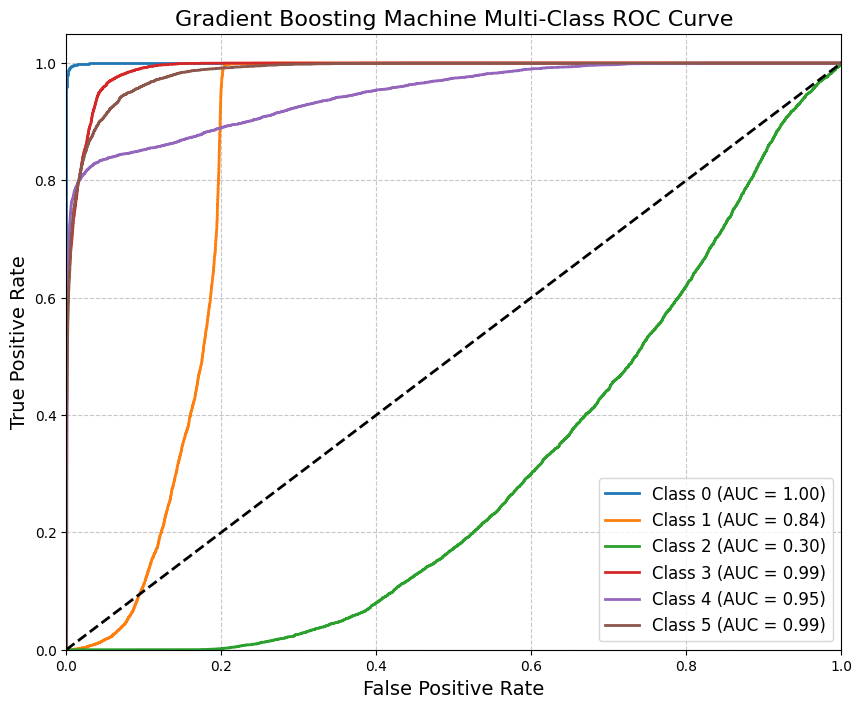

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np

def plot_multiclass_roc(y_true, model, X, n_classes, title='Multiclass ROC Curve'):
    # Binarize the output labels for multi-class plotting
    y_bin = label_binarize(y_true, classes=range(n_classes))
    n_classes = y_bin.shape[1]

    # Check if the model can predict probabilities
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X)
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at these points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        plt.figure(figsize=(10, 8))
        colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                        '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=14)
        plt.ylabel('True Positive Rate', fontsize=14)
        plt.title(title, fontsize=16)
        plt.legend(loc="lower right", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.gca().set_facecolor('white')
        plt.show()
    else:
        print("This model does not support probability estimates.")

# Example usage with your GBM model
n_classes = len(np.unique(y_train_encoded))  # Adjust based on the actual number of classes
plot_multiclass_roc(y_test_encoded, default_gbm, X_test, n_classes=n_classes, title='Gradient Boosting Machine Multi-Class ROC Curve')

    

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5ea8f536-739f-4c50-806e-84490cb7d5e0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>